In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def source(no_of_users, no_of_bits):
    # Generate a random binary matrix with shape (no_of_users, no_of_bits)
    # Each element is either 0 or 1
    return np.random.randint(0, 2, (no_of_users, no_of_bits))

no_of_users = 2  # Define the number of users
no_of_bits = 4  # Define the number of bits per user

# Generate the message bits as a binary matrix
msg_bits1 = source(no_of_users, no_of_bits)  # Generating bit stream of size (no_of_users, no_of_bits)
# Print the generated message bits
print("msg\n", msg_bits1)  # Each row represents the bit stream for one user

msg
 [[1 0 0 0]
 [0 0 1 1]]


In [3]:
def mod(bits):
    # Map binary values: 0 to -1 and 1 to 1
    return 2 * bits - 1

# Apply modulation to the message bits
symbols = mod(msg_bits1)
# Print the modulated symbols
print(symbols)


[[ 1 -1 -1 -1]
 [-1 -1  1  1]]


In [4]:
def awgn_mac_with_channel_coeff(symbols, snr_db):
    # Calculate the average power of the combined signal
    print("symbols\n",symbols)
    
    channel_coeff=np.random.randn(no_of_users,no_of_bits)
    print("channel coeff\n",channel_coeff,"\n")
    
    #multiplying with channel coeff
    
    symbols_with_fading=symbols*channel_coeff
    print("symols with fading\n",symbols_with_fading,"\n")
    
    # Sum the columns of the symbols array to combine signals from different users
    combined_symbols = np.sum(symbols_with_fading, axis=0)  # This corresponds to y = ∑h_i *x_i
    print("h_i+x_i\n",combined_symbols,"\n")
    
    
    signal_power = np.mean(np.abs(combined_symbols)**2)  # Signal power calculation
    
    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10.0)
    
    # Calculate noise variance based on the signal power and SNR
    noise_variance = signal_power / (2 * snr_linear)
    
    # Generate complex Gaussian noise with the calculated variance
    noise = np.sqrt(noise_variance) * np.random.randn(len(combined_symbols))  # Generating noise with accordance with signal power
  
    return combined_symbols +noise,combined_symbols

# Define the SNR in dB (array with one value in this case)
snr_db = np.arange(0, 1, 1)

# Pass the modulated symbols through the AWGN channel
received_signal,symbols_with_fading = awgn_mac_with_channel_coeff(symbols, snr_db)

# Print the received signal after adding noise
print(received_signal,"\n\n",symbols_with_fading)


symbols
 [[ 1 -1 -1 -1]
 [-1 -1  1  1]]
channel coeff
 [[ 0.01980292  0.36488457  0.32145253 -1.27165607]
 [ 2.10255267  0.01025943  0.31442032  1.39351609]] 

symols with fading
 [[ 0.01980292 -0.36488457 -0.32145253  1.27165607]
 [-2.10255267 -0.01025943  0.31442032  1.39351609]] 

h_i+x_i
 [-2.08274975 -0.375144   -0.00703221  2.66517216] 

[-1.64731888  0.36489962 -3.49342707  3.37852638] 

 [-2.08274975 -0.375144   -0.00703221  2.66517216]


In [5]:
def demod(received_signal2,symbols_with_fading):
    # Define the possible symbols for decoding
    symbols = [-2, 0, 2]  # The symbols that the noisy received signals will be decoded into
    
    # Initialize an empty list to store the demodulated symbols
    demodulated_symbols = []
    
    # Iterate over each received signal to decode it
    for i in received_signal:
        # Find the closest symbol to the received signal based on minimum distance
        closest_symbol = min(symbols, key=lambda s: np.abs(i - s))  # Decoding by finding the minimum distance
        demodulated_symbols.append(closest_symbol)  # Append the closest symbol to the list

    # Convert the list of demodulated symbols to a numpy array and return it
    return np.array(demodulated_symbols)

# Perform demodulation on the received signal
demod_symbols = demod(received_signal,symbols_with_fading)

# Print the demodulated symbols
print(demod_symbols)


[-2  0 -2  2]


In [6]:
def calculate_ber(msg, rec, no_of_users, no_of_bits):
    # Modulate the original message bits to get the transmitted symbols
    sym1 = mod(msg)
    
    # Sum the transmitted symbols across all users
    combined_symbols = np.sum(sym1, axis=0)  # This is used to compare with the received symbols
    
    # Print statements for debugging (currently commented out)
    # print(msg)
    # msg_sum = np.sum(msg, axis=0)
    # print("\n", msg_sum)
    # print("\n", rec)

    # Calculate the Bit Error Rate (BER) by comparing the combined transmitted symbols with the received symbols
    ber = np.mean(combined_symbols != rec)  # BER is calculated by averaging the number of symbol errors
    
    return ber

# Calculate the Bit Error Rate (BER) using the original message bits and the demodulated symbols
BER = calculate_ber(msg_bits1, demod_symbols, no_of_users, no_of_bits)

# Print the calculated BER
print(BER)


1.0


In [7]:
# Function to simulate the system for different SNR values
def simulate_with_channel_coeff(snr_db_range, msg_bits, no_of_users, no_of_bits):
    ber_with_channel_coeff = []  # Initialize an empty list to store Symbol Error Rate (SER) for each SNR value

    # Iterate over the range of SNR values
    for snr_db in snr_db_range:
        # Print the current SNR value for debugging (commented out)
        # print("snr=", snr_db)
        
        # Modulate the message bits to obtain transmitted symbols
        transmitted_symbols = mod(msg_bits)  # Modulation: bit stream --> symbols
        
        # Pass the transmitted symbols through the AWGN channel to get received symbols
        received_symbols ,_= awgn_mac_with_channel_coeff(transmitted_symbols, snr_db)  # Received symbols: channel output = symbols + noise
        
        # Demodulate the received symbols to recover the transmitted symbols
        demodulated_symbols = demod(received_symbols)  # Demodulation: noisy_symbols --> decoded symbols
        
        # Calculate the Symbol Error Rate (SER) and append it to the list
        ber_with_channel_coeff .append(calculate_ber(msg_bits, demodulated_symbols, no_of_users, no_of_bits))  # Calculate SER
    
        # Print BER for the current SNR value for debugging (commented out)
        # print(ber)
        # print("\n\n")

    return ber_with_channel_coeff   # Return the list of SER values for the given range of SNR values

# Define the range of SNR values (in dB) for the simulation
snr_db_range = np.arange(0, 12, 1)  # Input for SNR range to plot

# Run the simulation to obtain SER for each SNR value
ber_bpsk_sum_with_channel_coeff=simulate_with_channel_coeff(snr_db_range, msg_bits1, no_of_users, no_of_bits)

# Print the Bit Error Rate (BER) for each SNR value
# print(ber_bpsk_sum)



symbols
 [[ 1 -1 -1 -1]
 [-1 -1  1  1]]
channel coeff
 [[-0.69796261  0.17742855  0.76080336 -0.03398555]
 [-0.40107028 -1.19180166  0.55590379  0.88600276]] 

symols with fading
 [[-0.69796261 -0.17742855 -0.76080336  0.03398555]
 [ 0.40107028  1.19180166  0.55590379  0.88600276]] 

h_i+x_i
 [-0.29689233  1.0143731  -0.20489957  0.91998831] 



TypeError: demod() missing 1 required positional argument: 'symbols_with_fading'

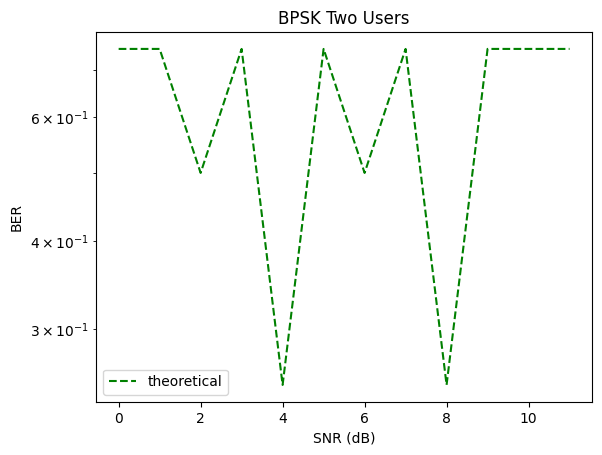

In [ ]:
# Convert SNR values from dB to linear scale
snr_lin = 10**(snr_db_range / 10)  # SNR in linear scale


# plt.semilogy(snr_db_range, ber_bpsk_sum_with_channel_coeff, linestyle='-', color="r", label='simulated')

# Plot the theoretical BER values
plt.semilogy(snr_db_range, ber_bpsk_sum_with_channel_coeff, linestyle='--', color='g', label='theoretical')

plt.xlabel("SNR (dB)")  
plt.ylabel("BER")       
plt.legend()         
plt.title("BPSK Two Users") 
# plt.grid(True)
plt.show()
